In [114]:
# import os
import SunStatistics as SS
from scipy.stats import pearsonr

# import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta,datetime
# from math import floor
# import seaborn as sns
# from matplotlib.colors import LinearSegmentedColormap

# import datetime as dt
import pytz
# from sklearn.utils import resample
# %matplotlib notebook
# import warnings
# from sklearn.model_selection import train_test_split
# from sklearn.neural_network import MLPRegressor as MPR
# from sklearn.preprocessing import Normalizer,StandardScaler,MinMaxScaler
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import classification_report,confusion_matrix
# from scipy.optimize import curve_fit
# from matplotlib.ticker import NullFormatter
# import Data_Processor as DP
# import importlib
# importlib.reload(DP)

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# from IPython.display import display, clear_output
# from ipywidgets import FloatProgress, HTML

G_Drive = 'G:\\My Drive\\'
Output_Path = G_Drive+'FishIsland_Outputs/'

# Model Functions

In [115]:
def Model_Test_RF(X,y,AllData,K=10,Task = 'Predict',min_samples_split=None,Verbose=True,random_state=1):
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Imp = []    
    Pred = []
    rnd=1
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y]).ravel()#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y]).ravel()#.reshape(-1, 1)
        Mod = RandomForestRegressor(min_samples_split=min_samples_split, random_state=random_state+rnd)#,bootstrap=False)
        rnd+=1
        Mod.fit(X_train, y_train)
        Test = Mod.predict(X_test)
        Pred.append(Mod.predict(AllData[X]))
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Imp.append(Mod.feature_importances_)
    Imp = np.mean(np.array(Imp),axis=0)
    Pred = np.mean(np.array(Pred),axis=0)
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.mean(np.array(MSE)**.5))
        print('std RMSE', np.std(np.array(MSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('Imp',np.round(Imp,3)*100)
    if Task == 'Predict':
        return(Pred)
    if Task == 'Predict_Return':
        return(Pred,Imp,MSE,R2)
    elif Task == 'Optimize':
        return(MSE)

def Model_Test_OLS(X,y,AllData,K=10,Task = 'Predict',fit_intercept=None,Scale=False,Verbose=True,random_state=1):
    if Scale==True:
        Mod = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=fit_intercept))
    else:
        Mod = make_pipeline(LinearRegression(fit_intercept=fit_intercept))
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Int = []
    Coef = []
    Pred = []
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y])#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y])#.reshape(-1, 1)
        Mod.fit(X_train, y_train)
        Test = Mod.predict(X_test)
        if y == ['VPD'] or y == ['PPFD_Avg']:
            Test[Test<0]=0
        
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Pred.append(Mod.predict(AllData[X]))
        Int.append(Mod[-1].intercept_)
        Coef.append(Mod[-1].coef_)
    Coef = np.mean(np.array(Coef),axis=0).mean(axis=0)
    Pred = np.mean(np.array(Pred),axis=0)#.mean(axis=0)
    Int = np.mean(np.array(Int))
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.mean(np.array(MSE)**.5))
        print('std RMSE', np.std(np.array(MSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('coef', Coef)
        print('int',Int)
    if Task == 'Predict':
        return(Pred)#.values)
    if Task == 'Predict_Return':
        return(Pred,Coef,Int,MSE,R2)
    elif Task == 'Optimize':
        return(MSE)
    
def Model_Test(X,y,AllData,K=10,Task = 'Predict',Test = 'OLS',min_samples_split=None,fit_intercept=True,Scale=False,Verbose=True,random_state=1):
    if Test == 'OLS':
        return(Model_Test_OLS(X,y,AllData,K=10,Task = Task,fit_intercept=fit_intercept,Scale=Scale,Verbose=Verbose,random_state=random_state))
    elif Test == 'RF':
        return(Model_Test_RF(X,y,AllData,K=10,Task = Task,min_samples_split=min_samples_split,Verbose=Verbose,random_state=random_state))
    

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues


In [116]:

def get_uv(Dir,U_bar,dec=0):
    M_dir = 270-(Dir+dec)
    U = np.cos(M_dir/180*np.pi)*U_bar
    V = np.sin(M_dir/180*np.pi)*U_bar
    return(U,V)
def get_wDir(u,v,m_dec=0):
    W_dir = np.arctan2(v,u)*180/np.pi
    W_dir = 270 - W_dir    
    W_dir[W_dir>360]-=360
    return(W_dir)

# Data

In [117]:
Taglu_Data = Output_Path+'Taglu_Data/Hourly.csv'
AWS = pd.read_csv(Taglu_Data,
parse_dates={'datetime':['Year','Month','Day','Time']}, 
).set_index('datetime')

# Gap Fill
C=['Air Temp','Net Radiation','Net SW Radiation','Net LW Radiation ','Wind Speed']
s = AWS.index.to_series()
print('Missing')
for c in C:
    print(c,AWS.loc[((AWS.index.month>=4)&(AWS.index.month<=10)),c].isnull().sum())
    miss = AWS[c].isna()
    #create consecutive groups
    g = miss.ne(miss.shift()).cumsum()
    #aggregate minimal 
    m1 = s.groupby(g).min()
    #get minimal of next groups, last value is replaced last value of index
    m2 = m1.shift(-1).fillna(AWS.index[-1])
    #get difference, convert to minutes
    out = m2.sub(m1).dt.total_seconds().div(3600).astype(int)
    AWS['Temp_Gap'] = g.map(out)
    AWS['Temp']=AWS[c].interpolate()
    AWS.loc[AWS['Temp_Gap']<=4,c]=AWS.loc[AWS['Temp_Gap']<=4,'Temp']
    AWS['Temp1']=AWS[c].shift(24)
    AWS['Temp2']=AWS[c].shift(-24)
    AWS.loc[AWS['Temp_Gap']>=4,c].fillna(AWS.loc[AWS['Temp_Gap']>=4,['Temp1','Temp2']].mean(axis=1))
AWS = AWS.drop(columns=['Temp_Gap','Temp','Temp1','Temp2'])
AWS_Rename = {'Air Temp':'Air_Temp',
              'Rainfall':'Rainfall',
              'Wind Speed':'Wind_Speed',
              'Wind direction':'Wind_Direction',
              'Net SW Radiation':'Net_SW',
              'Net LW Radiation ':'Net_LW',
              'Net Radiation':'Net_RN'}
AWS = AWS.rename(columns=AWS_Rename)
AWS_cols = list(AWS_Rename.values())

LAT = 69.371182
LON = -134.880935
TZ = -6

Temp = AWS[['Net_SW']].resample('5T').asfreq()
D = Temp.index.floor('D').to_julian_date()
T = Temp.index.hour/24
A = np.ones(D.shape[0])

Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset=SS.SunStats(LAT*A,LON*A,D.values,T.values,TZ*A)
Temp['Sun_Angle'] = Angle_Corr
Temp = Temp.resample('30T').mean()
try:
    AWS = AWS.drop(columns=['Sun_Angle'])
except:
    pass
AWS = AWS.join(Temp[['Sun_Angle']])

AWS['Daytime']=0
AWS.loc[AWS['Sun_Angle']>-0.5,'Daytime']=1

AWS.loc[((AWS['Daytime']==0)&(AWS['Net_SW']>3)),'Daytime']=0.5


Mt = pytz.timezone('Canada/Mountain')
UTC = AWS.index+timedelta(hours=6)
AWS = AWS.set_index(UTC)
AWS.index = AWS.index.tz_localize(pytz.utc).tz_convert(Mt)

U,V = get_uv(AWS['Wind_Direction'],AWS['Wind_Speed'])
AWS['U_bar_AWS'] = U
AWS['V_bar_AWS'] = V

AWS.groupby('Daytime').count()['Air_Temp']



Missing
Air Temp 40
Net Radiation 40
Net SW Radiation 40
Net LW Radiation  40
Wind Speed 40


C:\Users\wesle\Thesis_Code\SunStatistics.py:25: RuntimeWarning: invalid value encountered in arccos
  W2 = np.degrees(np.arccos(np.cos(np.radians(90.833))/(np.cos(np.radians(LAT))*np.cos(np.radians(T2)))-np.tan(np.radians(LAT))*np.tan(np.radians(T2)))) #HA Sunrise (deg)


Daytime
0.0    49491
0.5      346
1.0    54924
Name: Air_Temp, dtype: int64

# EC Data

In [118]:
EC_Data = pd.read_csv(Output_Path+'FI_Footprints_2022-02-23_2000mx2m.csv',delimiter = ',',header = 0,na_values = -9999,
                   index_col=['datetime'],
                  ).drop('Unnamed: 0',axis=1)
EC_Data = EC_Data.set_index(pd.to_datetime(EC_Data.index, utc=True)).tz_convert(Mt)
EC_Data = EC_Data.rename(columns={'Daytime':'Daytime_Raw',
                                 'Sun_Angle':'Sun_Angle_Raw'})

U,V=get_uv(EC_Data['wind_dir'],EC_Data['wind_speed'],dec=-22)
EC_Data['U_bar_EC']=U
EC_Data['V_bar_EC']=V

FSO = pd.read_csv(Output_Path+'Skeeter_et_al_2022_Day_Fix.csv',index_col=['datetime']).drop('Unnamed: 0',axis=1)#.drop('datetime.1',axis=1)

FSO = FSO.set_index(pd.to_datetime(FSO.index, utc=True)).tz_convert(Mt)
FSO = FSO.rename(columns={'NEE_est':'NEE_FSO',
                            'NME_est':'NME_FSO'})
EC_Data = EC_Data.join(FSO[['NEE_FSO',
'NME_FSO']])

kwargs = {'closed':'right','label':'left'}
EC_Data_r=EC_Data.resample('h',**kwargs).mean()
EC_Data_r['Rain_mm_Tot']=EC_Data.resample('h',**kwargs).sum()['Rain_mm_Tot']

EC_Data_r = EC_Data_r.drop(['Wind_Direction', 'Wind_Speed'],axis=1)
Data_M1 = EC_Data_r[
                    ['Temp_15_1','Temp_15_2','Temp_5_1','Temp_5_2','Table_1','VWC_1','Tdew','VPD','H',
                    'AirTC_Avg','PPFD_Avg','NR_Wm2_Avg','Rain_mm_Tot','Active_Layer_1',
                    'wind_speed','u*','U_bar_EC','V_bar_EC','Polygon','Rim',
                    'fch4','fco2','NEE_FSO','NME_FSO','ch4_flux','co2_flux']
                    ].join(AWS,how='outer')
Data_M1.head()

,Temp_15_1,Temp_15_2,Temp_5_1,Temp_5_2,Table_1,VWC_1,Tdew,VPD,H,AirTC_Avg,...,Rainfall,Wind_Speed,Wind_Direction,Net_SW,Net_LW,Net_RN,Sun_Angle,Daytime,U_bar_AWS,V_bar_AWS
datetime,,,,,,,,,,,,,,,,,,,,,
2008-08-28 00:00:00-06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.0,53.88,-0.53,-6.99,-7.51,-5.063956,0.0,-2.423352,-1.768435
2008-08-28 01:00:00-06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.2,56.81,-0.54,-6.18,-6.71,-8.302563,0.0,-2.677952,-1.751735
2008-08-28 02:00:00-06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.2,57.65,-0.55,-6.35,-6.90,-10.355872,0.0,-2.703345,-1.712287
2008-08-28 03:00:00-06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.9,56.24,-0.51,-5.40,-5.90,-11.078917,0.0,-2.410981,-1.611574
2008-08-28 04:00:00-06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.4,68.13,-0.44,-5.17,-5.61,-10.416418,0.0,-2.227275,-0.894005


# Merge

- Eddypro outputs have left labels (half hour timestamp corresponds to end of interval)
    * https://www.licor.com/documents/1ium2zmwm6hl36yz9bu4
- Need to close the right interval to match with AWS

In [119]:
for v1,v2 in zip(['Rain_mm_Tot','AirTC_Avg','wind_speed','NR_Wm2_Avg'],
                 ['Rainfall','Air_Temp','Wind_Speed','Net_RN']):
    DNA=Data_M1.loc[Data_M1['Active_Layer_1'].isnull()==False,[v1,v2]].dropna()
    print(v1,' ',v2)
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(3)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

Rain_mm_Tot   Rainfall
r2:  0.988
RMSE:  0.05
MBE:  -0.01

AirTC_Avg   Air_Temp
r2:  0.988
RMSE:  0.547
MBE:  -0.09

wind_speed   Wind_Speed
r2:  0.945
RMSE:  0.43
MBE:  0.0

NR_Wm2_Avg   Net_RN
r2:  0.978
RMSE:  43.069
MBE:  9.45



# ECMWF

- ECMWF data does not account for DST
    - Must offset by one hour so summer times match

In [120]:
ECMWF = pd.read_csv(G_Drive+'earthengine//Climate_Weighted_Mean_long.csv',
                    parse_dates=['system:index'],na_values=-9999,index_col=['system:index'])

UTC = ECMWF.index+timedelta(hours=-1)
ECMWF = ECMWF.set_index(UTC)
ECMWF.index = ECMWF.index.tz_localize(pytz.utc).tz_convert(Mt)
ECMWF = ECMWF.drop(columns=['.geo'])

ECMWF['Wind_10m']  =(ECMWF['u_component_of_wind_10m']**2+ECMWF['v_component_of_wind_10m']**2)**.5
ECMWF['HH']=ECMWF['surface_sensible_heat_flux_hourly']/3609*-1
for v in ['temperature_2m' ,'soil_temperature_level_1','soil_temperature_level_2','soil_temperature_level_3']:
    ECMWF[v]-=273.15
ECMWF['total_precipitation_hourly']=ECMWF['total_precipitation_hourly']*1000
ECMWF['RN']=ECMWF[[
    'surface_net_solar_radiation_hourly',
    'surface_net_thermal_radiation_hourly'
]].sum(axis=1)/3609

Data_M2 = Data_M1.join(ECMWF.loc[ECMWF.index.year>=2008],how = 'outer')

Data_M2['W_Dir_ERA5'] = get_wDir(Data_M2['u_component_of_wind_10m'].values,Data_M2['v_component_of_wind_10m'].values)
Data_M2['W_Dir_EC'] = get_wDir(Data_M2['U_bar_EC'].values,Data_M2['V_bar_EC'].values)

Data_M2['Wind_Direction']=Data_M2['Wind_Direction'].fillna(Data_M2['W_Dir_ERA5'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


,W_Dir_ERA5,Wind_Direction
W_Dir_ERA5,1.00000,0.78019
Wind_Direction,0.78019,1.00000


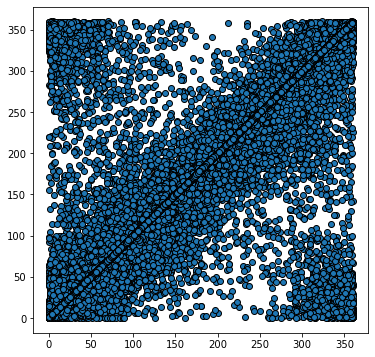

In [121]:

# DNA = Data_M2[['W_Dir_ERA5','Wind_Direction','W_Dir_EC']].dropna()
DNA = Data_M2.loc[((Data_M2.index.month>=5)&(Data_M2.index.month<=10)),['W_Dir_ERA5','Wind_Direction']].dropna()

plt.figure(figsize=(6,6))
plt.scatter(DNA['W_Dir_ERA5'],DNA['Wind_Direction'],edgecolor='k')
# plt.scatter(DNA['W_Dir_EC'],DNA['Wind_Direction'],edgecolor='k')

DNA[['W_Dir_ERA5','Wind_Direction']].corr()



In [122]:
InSitu = ['AirTC_Avg','Air_Temp','Tdew',
          'wind_speed','Wind_Speed','H','NR_Wm2_Avg','Net_RN']
ERA5 = ['temperature_2m','temperature_2m','dewpoint_temperature_2m',
        'Wind_10m','Wind_10m','HH','RN','RN']

for v1,v2 in zip(InSitu,ERA5):#,'Wind_Speed','Net_RN']):
    DNA=Data_M2.loc[((Data_M2.index.month>=5)&(Data_M2.index.month<=10)),[v1,v2]].dropna()
    print(v1,v2)
#     if v1 == 'H':
#         DNA[v2]/=-3600
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

AirTC_Avg temperature_2m
r2:  0.91
RMSE:  1.52
MBE:  0.53

Air_Temp temperature_2m
r2:  0.93
RMSE:  2.068
MBE:  -0.14

Tdew dewpoint_temperature_2m
r2:  0.85
RMSE:  1.682
MBE:  1.06

wind_speed Wind_10m
r2:  0.69
RMSE:  1.192
MBE:  -0.59

Wind_Speed Wind_10m
r2:  0.68
RMSE:  1.241
MBE:  -0.51

H HH
r2:  0.81
RMSE:  31.643
MBE:  -8.89

NR_Wm2_Avg RN
r2:  0.89
RMSE:  60.73
MBE:  13.45

Net_RN RN
r2:  0.86
RMSE:  51.625
MBE:  5.19



In [139]:
InSitu = ['Temp_5_1','Temp_5_2','Temp_5_1','Temp_5_2',
          'Temp_15_1','Temp_15_2','Temp_15_1','Temp_15_2',
          'VWC_1','VWC_1','Table_1','Table_1']
ERA5 = ['soil_temperature_level_1','soil_temperature_level_1','soil_temperature_level_2',
        'soil_temperature_level_2','soil_temperature_level_2','soil_temperature_level_2',
        'soil_temperature_level_3','soil_temperature_level_3',
        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2',
        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2']

for v1,v2 in zip(InSitu,ERA5):#,'Wind_Speed','Net_RN']):
    DNA=Data_M2.loc[((Data_M2.index.month>=5)&(Data_M2.index.month<=10)),[v1,v2]].dropna()
    print(v1,v2)
#     if v1 == 'H':
#         DNA[v2]/=-3600
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),3))
    print()

Temp_5_1 soil_temperature_level_1
r2:  0.43
RMSE:  7.169
MBE:  -5.912

Temp_5_2 soil_temperature_level_1
r2:  0.75
RMSE:  4.625
MBE:  -3.645

Temp_5_1 soil_temperature_level_2
r2:  0.67
RMSE:  4.928
MBE:  -4.58

Temp_5_2 soil_temperature_level_2
r2:  0.57
RMSE:  3.254
MBE:  -2.324

Temp_15_1 soil_temperature_level_2
r2:  0.09
RMSE:  8.332
MBE:  -7.754

Temp_15_2 soil_temperature_level_2
r2:  0.09
RMSE:  8.213
MBE:  -7.634

Temp_15_1 soil_temperature_level_3
r2:  0.32
RMSE:  4.325
MBE:  -4.059

Temp_15_2 soil_temperature_level_3
r2:  0.36
RMSE:  4.175
MBE:  -3.92

VWC_1 volumetric_soil_water_layer_1
r2:  0.29
RMSE:  0.084
MBE:  -0.03

VWC_1 volumetric_soil_water_layer_2
r2:  0.55
RMSE:  0.075
MBE:  -0.069

Table_1 volumetric_soil_water_layer_1
r2:  0.81
RMSE:  0.376
MBE:  -0.37

Table_1 volumetric_soil_water_layer_2
r2:  0.85
RMSE:  0.41
MBE:  -0.41



VWC_1                            0.215182
volumetric_soil_water_layer_2    0.301850
dtype: float64


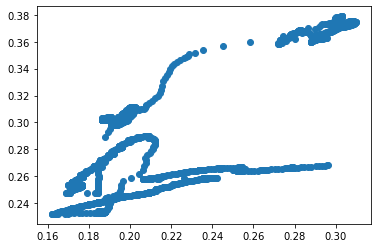

In [143]:
plt.figure()
plt.scatter(Data['VWC_1'],Data['volumetric_soil_water_layer_2'])
print(Data[['VWC_1','volumetric_soil_water_layer_2']].mean())

# Correlations

In [124]:
V = ['Temp_5_1','Temp_5_2',
    'Temp_15_1','Temp_15_2',
    'VWC_1','Table_1',
    'soil_temperature_level_1',
    'soil_temperature_level_2',
    'soil_temperature_level_3',
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
   ]
B = ['Temp_5_1','Temp_5_2',
   'Temp_15_1','Temp_15_2','VWC_1','Table_1']
P = calculate_pvalues(Data[V])[B][-5:].T.astype(float)

# P[P<=0.05]=-1
# P[P>0.05]=0
P=P*0+1
D =(Data[V].corr()[B][-5:].T**2).round(3)

PR = (P * D)

PR.to_csv(G_Drive+'\\PhD_Thesis\\Chapter3_Figs/Pearsonr.csv')
PR


,soil_temperature_level_1,soil_temperature_level_2,soil_temperature_level_3,volumetric_soil_water_layer_1,volumetric_soil_water_layer_2
Temp_5_1,0.427,0.668,0.319,0.221,0.267
Temp_5_2,0.748,0.567,0.130,0.233,0.262
Temp_15_1,0.021,0.086,0.315,0.006,0.000
Temp_15_2,0.012,0.090,0.358,0.007,0.000
VWC_1,0.245,0.542,0.737,0.286,0.553
Table_1,0.435,0.721,0.282,0.808,0.849


Rainfall total_precipitation_hourly
r2:  0.58
RMSE:  1.686
MBE:  -0.36

Rain_mm_Tot total_precipitation_hourly
r2:  0.5
RMSE:  2.679
MBE:  -0.73



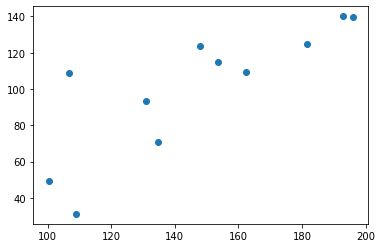

In [125]:
Daily = Data_M2.resample('D').sum()
InSitu=['Rainfall','Rain_mm_Tot']
ERA5=['total_precipitation_hourly','total_precipitation_hourly']
for v1,v2 in zip(InSitu,ERA5):
    DNA=Data_M2.loc[((Data_M2.index.month>=6)&(Data_M2.index.month<=9)&(Data_M2.index.year>=2009)&(Data_M2.index.year<=2019)),[v1,v2]].dropna()
    DNA = DNA.resample('D').mean().dropna()*24
    print(v1,v2)
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

Y = Daily.loc[((Daily.index.month>=6)&(Daily.index.month<=9)&(Daily.index.year>=2009)&(Daily.index.year<=2019))].resample('Y').sum()    

plt.figure()
plt.scatter(Y['total_precipitation_hourly'],Y['Rainfall'])

# Satelite & Stream

In [126]:
Gaus_interp_s = 2
Gaus_interp_p = 8
Gaus_interp_d = 32

NDVI = pd.read_csv(G_Drive+'earthengine/NDVI_NBAR_FI.csv',parse_dates=['date'],na_values=-9999)
NDVI = NDVI.set_index(pd.DatetimeIndex(NDVI['date']))
NDVI=NDVI.drop(['date','.geo','system:index','ndvi_FP'],axis=1)
NDVI.index = NDVI.index.tz_localize(pytz.utc).tz_convert(Mt)


GPP = pd.read_csv(G_Drive+'earthengine/GPP_Multi_Scale.csv',
                  parse_dates=['date'],na_values=-9999,index_col=['date']).dropna()
GPP.index = GPP.index.tz_localize(pytz.utc).tz_convert(Mt)

Snow = pd.read_csv(G_Drive+'earthengine/NDSI_One_Scale.csv',
                   parse_dates=['date'],na_values=['-9999'])
Snow = Snow.set_index(pd.DatetimeIndex(Snow['date']))
Snow=Snow.drop(['date','.geo','system:index'],axis=1)
Snow.index = Snow.index.tz_localize(pytz.utc).tz_convert(Mt)

Satelite = NDVI.join(Snow).join(GPP[['GPP_FI']])

print('Completeness')
Temp = Satelite.loc[((Satelite.index.month>=4)&(Satelite.index.month<=10))]
print((Temp.count()/Temp.shape[0]).round(2))


Satelite['NDSI_fill'] = Satelite['NDSI_FI'].rolling(Gaus_interp_d,center=True,min_periods=Gaus_interp_p, 
                                              win_type='gaussian').mean(std=Gaus_interp_s)
Satelite['NDSI_interp']=Satelite['NDSI_FI'].fillna(Satelite['NDSI_fill'])

Satelite['NDVI_fill'] = Satelite['ndvi_FI'].rolling(Gaus_interp_d,center=True,min_periods=Gaus_interp_p, 
                                              win_type='gaussian').mean(std=Gaus_interp_s)
Satelite['NDVI_interp']=Satelite['ndvi_FI'].fillna(Satelite['NDVI_fill'])

Satelite['GPP_interp'] = Satelite['GPP_FI'].rolling(8*4,center=True,min_periods=4, 
                                              win_type='gaussian').mean(std=Gaus_interp_s)/8

Gauge = pd.read_csv(Output_Path+'Gauge_Data.csv',
                   parse_dates=['Date'],na_values=['-9999'])
Gauge = Gauge.set_index(pd.DatetimeIndex(Gauge['Date']))
Gauge=Gauge.drop('Date',axis=1)
Gauge.loc[Gauge['EAST CHANNEL']>15,'EAST CHANNEL']=np.nan
Gauge.loc[((Gauge.index.year==2015)&(Gauge.index.dayofyear>=116)&
           (Gauge.index.dayofyear<=170)),'BIG LAKE']=np.nan
Gauge.index = Gauge.index.tz_localize(pytz.utc).tz_convert(Mt)

Data = Data_M2.join(Satelite).join(Gauge[['KULUARPAK','BIG LAKE']])
Data.head()

Completeness
ndvi_FI    0.96
NDSI_FI    0.54
GPP_FI     0.08
dtype: float64


,Temp_15_1,Temp_15_2,Temp_5_1,Temp_5_2,Table_1,VWC_1,Tdew,VPD,H,AirTC_Avg,...,ndvi_FI,NDSI_FI,GPP_FI,NDSI_fill,NDSI_interp,NDVI_fill,NDVI_interp,GPP_interp,KULUARPAK,BIG LAKE
2008-01-01 00:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 01:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 02:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 03:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 04:00:00-07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Fill Params

In [127]:
Data['DOY']=Data.index.dayofyear
Data['NDSI_interp'] = Data['NDSI_interp'].interpolate()
Data['NDVI_interp'] = Data['NDVI_interp'].interpolate()


In [128]:
# Data[['temperature_2m','Air_Temp']].corr()**2

# calculate_pvalues(Data[['temperature_2m','AirTC_Avg']])

# Sub-Surface Fill

In [129]:
Data['Rolling_RainfallD14']=Data['Rainfall'].rolling(str(14)+'D').sum()
Data['Rolling_RainfallD6']=Data['Rainfall'].rolling(str(6)+'D').sum()
Data['Rolling_RainfallD3']=Data['Rainfall'].rolling(str(3)+'D').sum()
Data['Rolling_RainfallD']=Data['Rainfall'].rolling(str(1)+'D').sum()

# Data['Rolling_Air_Temp_D14']=Data['Air_Temp'].rolling(str(14)+'D').mean()
# Data['Rolling_Air_Temp_D6']=Data['Air_Temp'].rolling(str(6)+'D').mean()
Data['Rolling_Air_TempD3']=Data['Air_Temp'].rolling(str(3)+'D').mean()
Data['Rolling_Air_TempD']=Data['Air_Temp'].rolling(str(1)+'D').mean()

Data['Rolling_Air_TempH1']=Data['Air_Temp'].rolling(str(6)+'H').mean()
Data['Rolling_Air_TempH2']=Data['Air_Temp'].rolling(str(12)+'H').mean()
Data['Rolling_Air_TempH3']=Data['Air_Temp'].rolling(str(18)+'H').mean()

Y = 'Test'

SE_Rule = 2

Met = [
    'Net_RN',
    'Air_Temp',
    'Rainfall'
    ]
Lag_Rain = [
    'Rolling_RainfallD3',
    ]
Lag_Air = [
    'Rolling_Air_TempH1',
    'Rolling_Air_TempH2',
    'Rolling_Air_TempH3',
    'Rolling_Air_TempD'
    ]
ERA5_Temp = [
    'soil_temperature_level_1',
    'soil_temperature_level_2',
    'soil_temperature_level_3'
    ]

ERA5_VWC = [
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
    ]

AllX = Met+Lag_Air+Lag_Rain+ERA5_Temp+ERA5_VWC
print(len(AllX))

Mods = {
}
for y in [['Temp_15_1'],['Temp_15_2'],['Temp_5_1'],['Temp_5_2'],['Table_1']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 30
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
            'R2':[],
            'R2S':[]}
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
        MSE = np.array(MSE)**.5
        Results['Score'] = C**2/(C**2).sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
#     Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2','R2S']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print(Sel)
#     print(Track)
    print()

13
['Temp_15_1']
['soil_temperature_level_2' 'soil_temperature_level_1'
 'volumetric_soil_water_layer_2' 'soil_temperature_level_3' 'Air_Temp'
 'Rolling_Air_TempH1' 'Net_RN' 'Rolling_Air_TempH2' 'Rolling_Air_TempD'
 'Rolling_Air_TempH3']
        RMSE     RMSES        R2       R2S
i                                         
10  0.427633  0.016588  0.911295  0.007369

['Temp_15_2']
['volumetric_soil_water_layer_2' 'Rolling_Air_TempH2' 'Rolling_Air_TempH3'
 'Rolling_Air_TempD' 'Net_RN' 'soil_temperature_level_3' 'Air_Temp'
 'Rolling_Air_TempH1']
       RMSE    RMSES        R2       R2S
i                                       
8  0.491913  0.02941  0.881958  0.015184

['Temp_5_1']
['Net_RN' 'Rolling_Air_TempD' 'soil_temperature_level_3'
 'Rolling_Air_TempH3' 'Rolling_Air_TempH2' 'Air_Temp' 'Rolling_Air_TempH1']
       RMSE     RMSES        R2       R2S
i                                        
7  0.744986  0.021467  0.900956  0.008411

['Temp_5_2']
['soil_temperature_level_1' 'Air_Temp' 'Ro

        RMSE     RMSES        R2       R2S
i                                         
10  0.427633  0.016588  0.911295  0.007369

r2:  0.9133046003848395
RMSE:  0.4254254585950848
       RMSE    RMSES        R2       R2S
i                                       
8  0.491913  0.02941  0.881958  0.015184

r2:  0.8839400323187027
RMSE:  0.49033934226627257
       RMSE     RMSES        R2       R2S
i                                        
7  0.744986  0.021467  0.900956  0.008411

r2:  0.9029460738787796
RMSE:  0.7418671815115997
       RMSE     RMSES        R2       R2S
i                                        
6  1.220722  0.058471  0.863256  0.013359

r2:  0.8661710926050494
RMSE:  1.2163082166458539
       RMSE     RMSES        R2       R2S
i                                        
4  0.007089  0.000468  0.952754  0.007887

r2:  0.9537124568529606
RMSE:  0.0070822255798179525


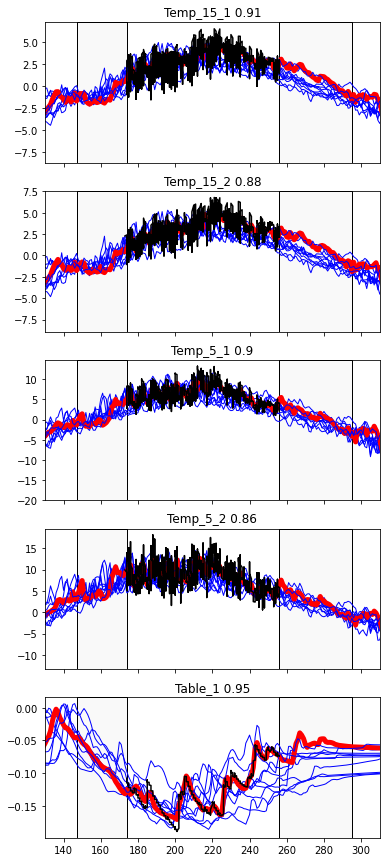

In [130]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=False)
    Data[Y+'_OLS']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_OLS']=Val
                     
    DNA = Data[y+[Y+'_OLS']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_OLS']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_OLS'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))


    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].set_xlim(130,310)
    j +=1

In [131]:
Data['Rolling_Rainfall_D14']=Data['Rainfall'].rolling(str(14)+'D').sum()
Data['Rolling_Rainfall_D6']=Data['Rainfall'].rolling(str(6)+'D').sum()
Data['Rolling_Rainfall_D3']=Data['Rainfall'].rolling(str(3)+'D').sum()
Data['Rolling_Rainfall_D']=Data['Rainfall'].rolling(str(1)+'D').sum()

# Data['Rolling_Air_Temp_D14']=Data['Air_Temp'].rolling(str(14)+'D').mean()
# Data['Rolling_Air_Temp_D6']=Data['Air_Temp'].rolling(str(6)+'D').mean()
Data['Rolling_Air_Temp_D3']=Data['Air_Temp'].rolling(str(3)+'D').mean()
Data['Rolling_Air_Temp_D']=Data['Air_Temp'].rolling(str(1)+'D').mean()

Data['Rolling_Air_TempH1']=Data['Air_Temp'].rolling(str(6)+'H').mean()
Data['Rolling_Air_TempH2']=Data['Air_Temp'].rolling(str(12)+'H').mean()
Data['Rolling_Air_TempH3']=Data['Air_Temp'].rolling(str(18)+'H').mean()

Y = 'Test'

SE_Rule = 2

Met = [
#     'Net_LW',
#     'Net_SW',
    'Net_RN',
    'Wind_Speed',
#     'U_bar_AWS',
#     'V_bar_AWS',
    'Air_Temp',
    'Rainfall'
    ]
ERA5_Met = [
    'temperature_2m',
    'dewpoint_temperature_2m',
    'Wind_10m',
    'HH',
    ]


AllX = Met+ERA5_Met
print(len(AllX))

Mods = {
}
for y in [['u*'],['PPFD_Avg']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 30
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
            'R2':[],
            'R2S':[]}
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
        MSE = np.array(MSE)**.5
        Results['Score'] = C**2/(C**2).sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
    Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2','R2S']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print(Sel)
    print(Track)
    print()

8
['u*']
['Wind_Speed']
       RMSE     RMSES       R2       R2S
i                                       
1  0.045001  0.003854  0.89794  0.017879
                       Rem      RMSE     RMSES        R2       R2S    RMSESS  \
i                                                                              
8                 Rainfall  0.043031  0.003552  0.906915  0.014951  0.050134   
7                 Wind_10m  0.043016  0.003586  0.906972  0.015016  0.050187   
6  dewpoint_temperature_2m  0.043016  0.003661  0.906950  0.015274  0.050338   
5           temperature_2m  0.043039  0.003680  0.906855  0.015349  0.050399   
4                   Net_RN  0.043034  0.003672  0.906872  0.015382  0.050379   
3                 Air_Temp  0.043114  0.003662  0.906527  0.015405  0.050438   
2                       HH  0.043622  0.004066  0.904160  0.017376  0.051754   
1               Wind_Speed  0.045001  0.003854  0.897940  0.017879  0.052710   

       R2SS  
i            
8  0.877014  
7  0.87694

       RMSE     RMSES       R2       R2S
i                                       
1  0.045001  0.003854  0.89794  0.017879

u*
RMSE 0.045001494405219875
std RMSE 0.0038542468485703884
r2 0.8948652491619089
coef [0.13501616]
int 0.30444814205986764

r2:  0.8998657373147907
RMSE:  0.0450412910881427
        RMSE     RMSES        R2       R2S
i                                         
2  54.513591  3.409599  0.980361  0.002428

PPFD_Avg
RMSE 54.513591120933484
std RMSE 3.409598739122998
r2 0.9796140043212151
coef [ 30.79901424 371.32319588]
int 333.84664621212124

r2:  0.9761672667790758
RMSE:  60.453691591999345


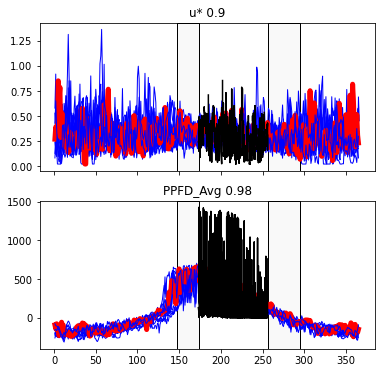

In [132]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=True)
    Data[Y+'_OLS']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_OLS']=Val
                     
    DNA = Data[y+[Y+'_OLS']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_OLS']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_OLS'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))
    
    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    j +=1

In [133]:
Data['Rolling_Rainfall_D14']=Data['Rainfall'].rolling(str(14)+'D').sum()
Data['Rolling_Rainfall_D6']=Data['Rainfall'].rolling(str(6)+'D').sum()
Data['Rolling_Rainfall_D3']=Data['Rainfall'].rolling(str(3)+'D').sum()
Data['Rolling_Rainfall_D']=Data['Rainfall'].rolling(str(1)+'D').sum()

# Data['Rolling_Air_Temp_D14']=Data['Air_Temp'].rolling(str(14)+'D').mean()
# Data['Rolling_Air_Temp_D6']=Data['Air_Temp'].rolling(str(6)+'D').mean()
Data['Rolling_Air_Temp_D3']=Data['Air_Temp'].rolling(str(3)+'D').mean()
Data['Rolling_Air_Temp_D']=Data['Air_Temp'].rolling(str(1)+'D').mean()

Data['Rolling_Air_TempH1']=Data['Air_Temp'].rolling(str(6)+'H').mean()
Data['Rolling_Air_TempH2']=Data['Air_Temp'].rolling(str(12)+'H').mean()
Data['Rolling_Air_TempH3']=Data['Air_Temp'].rolling(str(18)+'H').mean()

Y = 'Test'

SE_Rule = 2

Met = [
    
    'Net_RN',
#     'Wind_Speed',
    'Air_Temp',
#     'Rainfall'
    ]
ERA5_Met = [
    'temperature_2m',
    'dewpoint_temperature_2m',
    'W_Dir_ERA5',
    'Wind_10m',
    'HH',
    ]


AllX = Met+ERA5_Met
print(len(AllX))

Mods = {
}
for y in [['VPD']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 10
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
            'R2':[],
            'R2S':[]}
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'RF',Task='Predict_Return',Verbose=False,min_samples_split=2)
        MSE = np.array(MSE)**.5
        Results['Score'] = C#/C.sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
    Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2','R2S']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print(Sel)
    print(Track)
    
    print()

7
['VPD']
['Net_RN' 'dewpoint_temperature_2m' 'Air_Temp']
         RMSE     RMSES        R2       R2S
i                                          
3  111.510566  8.874894  0.900403  0.029829
                       Rem        RMSE     RMSES        R2       R2S  \
i                                                                      
7                 Wind_10m   97.718069  8.214041  0.923856  0.021567   
6               W_Dir_ERA5   98.385452  8.422388  0.922693  0.022233   
5                       HH  102.289242  8.586191  0.916597  0.023048   
4           temperature_2m  104.162249  9.032933  0.913392  0.024708   
3                   Net_RN  111.510566  8.874894  0.900403  0.029829   
2  dewpoint_temperature_2m  120.140625  8.115061  0.884962  0.029984   
1                 Air_Temp  169.981249  7.801545  0.770562  0.047739   

       RMSESS      R2SS  
i                        
7  114.146152  0.880722  
6  115.230228  0.878226  
5  119.461624  0.870500  
4  122.228114  0.863975  
3  12

         RMSE     RMSES        R2       R2S
i                                          
3  111.510566  8.874894  0.900403  0.029829

r2:  0.9825894925456964
RMSE:  47.67643694793786


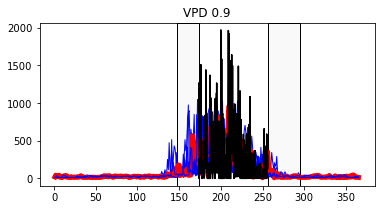

In [134]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
if len(Mods.keys())==1:
    ax = [ax]
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'RF',Scale=True,Task='Predict',Verbose=False,min_samples_split=2)
    Data[Y+'_RF']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_RF']=Val
                     
    DNA = Data[y+[Y+'_RF']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_RF']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_RF'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_RF'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_RF'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))


    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    j +=1

In [135]:
Daily = Data.resample('D').mean()
Daily = Daily.loc[((Daily.index.month>=5)&(Daily.index.month<=10))].copy()
Flood = Daily.loc[((Daily.index.month>=5)&(Daily.index.month<=6))].copy()

Flood['ct']=1
data={
    'Year':[],    'Site':[],
    'Peak_Day':[],    'Peak_Height':[],
    'Peak_NDVI':[],    'Peak_Snow':[],
    'NDVI_end':[],     'NDVI_start':[],
     'Start_height':[],     'End_height':[],
     'Year':[],     'Day_start':[],
     'Day_end':[],     'NDSI_end':[],
     'NDSI_start':[],     'NDVI_mid':[],     'NDSI_mid':[],   #  'NDSI_end':[]
}

for y in range(2006,2018):
    Fy=Flood.loc[Flood.index.year==y].copy()
    for s in ['KULUARPAK']:#,'BIG LAKE']:
        if Fy[s].count()/(1464/24)>.8:
            
            v=Fy[s].max()
            d = Fy.loc[((Fy[s]==v))].index.dayofyear[0]
            
            K = (Daily.loc[((Daily.index.year==y)&(Daily['DOY']==d)),
                    ['NDSI_interp','NDVI_interp']].values[0])
            
            data['Year'].append(y)
            data['Site'].append(s)
            data['Peak_Day'].append(d)
            data['Peak_Height'].append(v)
            data['Peak_Snow'].append(K[0])
            data['Peak_NDVI'].append(K[1])
            Fy['Diff']=Fy[s].diff()
            Fy['Diff2']=Fy['Diff']*1
            Fy.loc[Fy['Diff']>0,'Diff2']=-10
            Fy.loc[Fy['Diff']<0,'Diff2']=1
            n=1
            Fy['mm'] = ~Fy['Diff2'].diff().fillna(0).le(n)#.shift(-1)
            Fy['m'] = Fy['mm'].shift(-1)
            Fy['Grp']=Fy['m'].cumsum()
            Fy.loc[Fy['Diff']>=0,'Grp']=np.nan
            Fg = Fy.groupby(Fy['Grp']).sum()
            Fgv = (Fg.loc[Fg['Diff'] == Fg['Diff'].min()])
            data['Start_height'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0],[s]].max().values[0])
            data['End_height'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0],[s]].min().values[0])
            data['NDVI_start'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0],['NDVI_interp']].min().values[0])
            data['NDVI_mid'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0],['NDVI_interp']].median().values[0])
            data['NDVI_end'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0],['NDVI_interp']].max().values[0])
            data['NDSI_end'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0],['NDSI_interp']].min().values[0])
            data['NDSI_start'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0],['NDSI_interp']].max().values[0])
            data['NDSI_mid'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0],['NDSI_interp']].median().values[0])
#             data['NDSI_end'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0],['NDSI_interp']].min().values[0])
            data['Day_start'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0]].index.dayofyear[0])
            data['Day_end'].append(Fy.loc[Fy['Grp']==Fgv.index.values[0]].index.dayofyear[-1])
            if y == 2008:
                Fyall = Fy.loc[Fy['Grp']==Fgv.index.values[0],['NDVI_interp','KULUARPAK']]*1
            else:
                Fyall = Fyall.append(Fy.loc[Fy['Grp']==Fgv.index.values[0],['NDVI_interp','KULUARPAK']]*1)

FDF = pd.DataFrame(data=data)
FDF['Drop'] = FDF['Start_height']-FDF['End_height']
FDF = FDF.groupby(['Year','Site']).first()
FDF
print(Data.loc[((Data.index.year==2017)&(Data.index.month>3)&
                (Data['NDSI_interp']<=FDF['Peak_Snow'].median()))].index[0])
FDF = FDF.reset_index().set_index('Year')
print('Peak Flood Day: ',np.round(FDF['Peak_Day'].median(),2))
print('Start of Flood Drop: ',np.round(FDF['Day_start'].median(),2))
print('End of Flood Day: ',np.round(FDF['Day_end'].median(),2))
print('Peak Snow Cover: ',np.round(FDF['Peak_Snow'].median(),2))
print('Peak NDVI: ',np.round(FDF['Peak_NDVI'].median(),2))
print('Start of Flood Snow: ',np.round(FDF['NDSI_start'].median(),2))
print('Start of Flood Green: ',np.round(FDF['NDVI_start'].median(),2))
print('Middle of Flood Snow: ',np.round(FDF['NDSI_mid'].median(),2))
print('Middle of Flood Green: ',np.round(FDF['NDVI_mid'].median(),2))
print('End of Flood Green: ',np.round(FDF['NDVI_end'].median(),2))
print('Start of 2017 Study: ',Data.loc[Data['Active_Layer_1'].isnull()==False,'DOY'].min())
print('Start of 2017 Green: ',Data.loc[Data['Active_Layer_1'].isnull()==False,'NDVI_interp'].min())

Daily['Snow']=1
Daily.loc[Daily['NDSI_interp']>FDF['Peak_Snow'].median(),'Snow']=np.nan
Daily.loc[Daily['NDSI_interp']>20,'Snow']=np.nan
Daily['Green']=1
Daily.loc[Daily['NDVI_interp']<FDF['NDVI_end'].median(),'Green']=np.nan
Daily['Freezing'] = 1# np.nan
Daily.loc[Daily['Air_Temp']<0,'Freezing']=np.nan

Daily['DOY_Snow']=Daily['DOY']*Daily['Snow']
Daily['DOY_Green']=Daily['DOY']*Daily['Green']/Daily['Green'].max()
Daily['DOY_Freezing']=Daily['DOY']*Daily['Freezing']

Daily['Season']=0#np.nan
Daily['Season2']=(Daily['Freezing'].fillna(0)*(Daily['Snow'].fillna(0)+Daily['Green'].fillna(0)))
Daily['Season3']=1

FDF['Flood_Snow'] = np.nan
FDF['Flood_NDVI'] = np.nan
Start_Year=2008
End_Year=2020

for y in range(Start_Year,End_Year+1):
    Year = Daily.loc[Daily.index.year==y].copy()

#     Year.loc[((Year['DOY']>=Year['DOY_Green'].min())&
#               (Year['DOY']<=Year['DOY_Green'].max())),'Season']=1
    Year.loc[((Year['DOY']>=Year['DOY_Green'].min())&
              (Year['DOY']<=Year['DOY_Snow'].max())),'Season']=1
    Year.loc[((Year['DOY']>Year['DOY_Freezing'].max())),'Season']=0#np.nan
       
    S21 = Year.loc[Year['Season2']>0].index.dayofyear[0]
    S212 = Year.loc[Year['Season2']>1].index.dayofyear[0]
    S22 = Year.loc[Year['Season2']>0].index.dayofyear[-1]
    
    Year.loc[((Year.index.dayofyear<S21)|(Year.index.dayofyear>S22)),'Season3']=np.nan
    
    Daily.loc[Daily.index.year==y,'Season']=Year['Season']*1
    Daily.loc[Daily.index.year==y,'Season2']=Year['Season2']*1
    Daily.loc[Daily.index.year==y,'Season3']=Year['Season3']*1
    Daily.loc[Daily.index.year==y,'Season_Sum']=Year['Season'].cumsum()
    Daily.loc[Daily.index.year==y,'Season_Sum2']=Year['Season2'].cumsum()
    FDF.loc[FDF.index==y,'Flood_Snow']=S21
    FDF.loc[FDF.index==y,'Flood_NDVI']=S212
    
print(FDF[['Peak_Day','Flood_Snow','Flood_NDVI']].corr()**2)

Daily['Season_Root']=Daily['Season_Sum']**.5
Daily['Season_Root2']=Daily['Season_Sum2']**.5

Data['Season']=Daily['Season'].resample('1H').ffill()
Data['Season2']=Daily['Season2'].resample('1H').ffill()
Data['Season3']=Daily['Season3'].resample('1H').ffill()

Data['Season_Sum']=Daily['Season_Sum'].resample('1H').interpolate()#*Data['Season']
Data['Season_Sum2']=Daily['Season_Sum2'].resample('1H').interpolate()#*Data['Season3']

Data['Season_Root']=Data['Season_Sum']**.5
Data['Season_Root2']=Data['Season_Sum2']**.5

Data = Data.loc[((Data.index.year >= Start_Year)&
                 (Data.index.year <= End_Year)&
                (Data.index.month>=4)&
               (Data.index.month<=10))].copy()
Data.loc[Data['Season']==0,'Season']=np.nan

Data['Season_Days']=(Data['DOY']*Data['Season'])
print(Data['Season_Days'].describe())

2017-05-27 12:00:00-06:00
Peak Flood Day:  150.0
Start of Flood Drop:  151.0
End of Flood Day:  159.0
Peak Snow Cover:  12.66
Peak NDVI:  0.09
Start of Flood Snow:  8.39
Start of Flood Green:  0.12
Middle of Flood Snow:  0.67
Middle of Flood Green:  0.21
End of Flood Green:  0.26
Start of 2017 Study:  174
Start of 2017 Green:  0.3602129424071088
            Peak_Day  Flood_Snow  Flood_NDVI
Peak_Day    1.000000    0.197181    0.531251
Flood_Snow  0.197181    1.000000    0.683094
Flood_NDVI  0.531251    0.683094    1.000000
count    35760.000000
mean       218.962416
std         34.063563
min        147.000000
25%        190.000000
50%        219.000000
75%        248.000000
max        295.000000
Name: Season_Days, dtype: float64


[10, 10, 10, 10, 10]
AL Comparisson
Reindeer Depot  (Thaw tube)
0.8462020603197233

Lousy Point (Thaw tube)
0.7411188723538236
              Reindeer Depot  (Thaw tube)  Lousy Point (Thaw tube)
Snow                                0.706                    0.423
Green                               0.608                    0.578
Season                              0.846                    0.740
Air_Temp                            0.476                    0.490
Season_Sum                          0.846                    0.740
Season_Sum2                         0.902                    0.740
Season_Root                         0.846                    0.740
Season_Root2                        0.902                    0.757
Day_end                               NaN                   -0.372


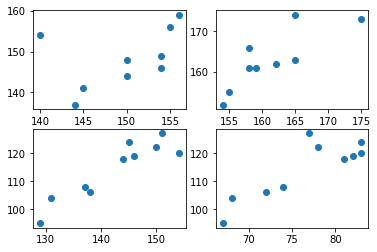

In [136]:
Ary = {
    'O':np.zeros(10),
        'A':44.5-np.array([23, 21.5, 23.5, 23, 21.5, 23, 22, 22, 22.5, 23.5,]) ,    
        'B':np.array([28, 28, 28, 32, 30, 30, 30, 32, 28, 29,]),    
        'C':np.array([34, 33, 36, 37, 36, 35, 34, 34, 36, 35,]),    
        'D':np.array([40, 40, 41, 42, 43, 46, 44, 48, 43, 44,]),
        'E':np.array([53, 51, 54, 52, 54, 54, 53, 49, 47, 46,])
        }
# F = np.ones(10)
DD = [
#     '2017-5-27',
    '2017-6-22','2017-7-10','2017-8-1','2017-8-21','2017-9-13']
P = []
for d in DD:
    P.append(10)
print(P)
# P = [10,10,10,10,10,10]
D = [DD[i] for i,p in enumerate(P) for s in range(p) ]
KK = [
#     'O',
      'A','B','C','D','E']
AP = []
DT = []

for d,k,p in zip (DD,KK,P):
    AP.append(Ary[k])
    DT.append(np.array([d for i in range(p)]))
    
# print(len(AP))
Set = {'Active_Layer_1':np.hstack(AP)/100,
             'Dt':np.hstack(DT)}    
AL_obs = pd.DataFrame(data=Set)

AL_obs['Date'] = pd.DatetimeIndex(AL_obs['Dt'])
AL_obs=AL_obs.set_index('Date')


Days = Daily.groupby(Daily.index.year).first()[['DOY_Snow','DOY_Green']]

ALH=pd.read_csv(Output_Path+'AL_Depth.csv',header=[1])
AL=pd.read_csv(Output_Path+'AL_Depth.csv',skiprows=4)
AL.columns=ALH.columns
AL=AL.rename(columns={'Name':'Year'})
AL = AL.set_index('Year')

AL = AL[['Reindeer Depot  (Thaw tube)','Lousy Point (Thaw tube)']].dropna()

T = Daily.loc[Daily.index.year>=Start_Year].resample('Y').sum()[['Snow',
                                                           'Green',
                                                           'Freezing',
                                                           'Season']]

T[['Air_Temp']] = Daily.loc[Daily.index.year>=Start_Year].resample('Y').mean()[['Air_Temp']]
T[['Season_Sum','Season_Sum2','Season_Root','Season_Root2']
 ] = Daily.loc[Daily.index.year>=Start_Year].resample('Y').max()[['Season_Sum','Season_Sum2',
                                                            'Season_Root','Season_Root2']]

# print(T)

T['Year']=T.index.year
T = T.set_index('Year')
AL = AL.join(T).join(FDF).join(Days)

C = ((AL.corr()).round(2)[['Reindeer Depot  (Thaw tube)','Lousy Point (Thaw tube)']][2:])
S = np.sign(C)#*10
C = S.multiply(C**2).round(3)
C[C.abs()<.3]=np.nan

fig,ax=plt.subplots(2,2)
ax[0,0].scatter(AL['Peak_Day'],AL['DOY_Snow'])
ax[0,1].scatter(AL['Day_end'],AL['DOY_Green'])
ax[1,0].scatter(AL['Reindeer Depot  (Thaw tube)'],AL['Season_Sum'])
ax[1,1].scatter(AL['Lousy Point (Thaw tube)'],AL['Season_Sum'])

AL_s = 'Reindeer Depot  (Thaw tube)'
v = 'Season_Root2'
v = 'Season_Sum'
df = AL[[AL_s,v]].dropna()
Mod = LinearRegression()
Mod.fit(df[[AL_s]], df[v])
Test = Mod.predict(df[[AL_s]])
print('AL Comparisson')
print(AL_s)
print(metrics.r2_score(df[v],Test))

AL_s = 'Lousy Point (Thaw tube)'
# v = 'Season'
df = AL[[AL_s,v]].dropna()
Mod = LinearRegression()
Mod.fit(df[[AL_s]], df[v])
Test = Mod.predict(df[[AL_s]])
print()
print(AL_s)
print(metrics.r2_score(df[v],Test))

print(C[C.isnull().sum(axis=1)<2])
# AL.dropna()
# AL


Active_Layer_1
RMSE 0.02516828104614883
std RMSE 0.005859607102972266
r2 0.9174551454471089
coef [0.04634861]
int 0.03912272002742073
0.8468832150807294
[[341.68066729]] [-40.01478002]
0.8191996461936317
2.358109116926644

0.7472671183070791
[[228.08877271]] [-45.33765767]
0.6617904421306767
2.379391641900031

                             AL_data_est  AL_data_est  \
AL_data_est                     1.000000     1.000000   
AL_data_est                     1.000000     1.000000   
Reindeer Depot  (Thaw tube)     0.846883     0.846883   
Lousy Point (Thaw tube)         0.747267     0.747267   

                             Reindeer Depot  (Thaw tube)  \
AL_data_est                                     0.846883   
AL_data_est                                     0.846883   
Reindeer Depot  (Thaw tube)                     1.000000   
Lousy Point (Thaw tube)                         0.729840   

                             Lousy Point (Thaw tube)  
AL_data_est                                 0

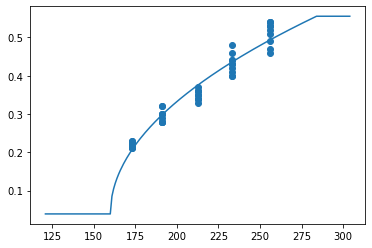

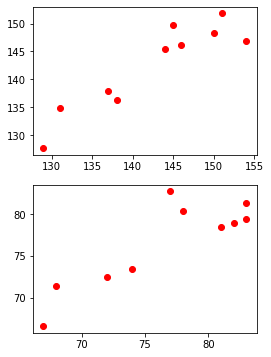

In [137]:
for v in [
    'DOY',
    'Season_Sum',
    'Season_Root',
    'Season_Sum2',
    'Season_Root2'
    ]:
    for d in AL_obs.index.unique():
        AL_obs.loc[AL_obs.index==d,v]=Daily.loc[Daily.index.date==d,v].values[0]

y=['Active_Layer_1']
Y = 'AL_data_est'
Lag = []
D = []
K = 10

X = ['Season_Sum']
X = ['Season_Root']

Val,C,I,RMSE,R2 = Model_Test(X,y,AL_obs.copy(),K=K,Test = 'OLS',Task='Predict_Return')
AL_obs[Y]=Val

Daily['AL_data_est'] = (Daily[X[0]])*C+I
Data['AL_data_est'] = (Data[X[0]])*C+I

Daily.loc[Daily['AL_data_est']<=0,'AL_data_est']=np.nan

fig,ax=plt.subplots()
for y in range(2017,2018):
    Yr = Daily.loc[Daily.index.year==y]#.resample('D').mean()
    ax.plot(Yr['DOY'],Yr['AL_data_est'])#*Yr['DSF'])
ax.scatter(AL_obs['DOY'],AL_obs['Active_Layer_1'])

# ALH=pd.read_csv('AL_Depth.csv',header=[1])
# AL=pd.read_csv('AL_Depth.csv',skiprows=4)
# AL.columns=ALH.columns
# AL=AL.rename(columns={'Name':'Year'})
# AL = AL.set_index('Year')

AL = AL[['Reindeer Depot  (Thaw tube)','Lousy Point (Thaw tube)']].dropna()

# AL = AL.drop(columns='AL_data_est')
T = Daily.loc[Daily.index.year>=Start_Year].resample('Y').max()[['AL_data_est']]
# T['Snow'] = Data.loc[Data.index.year>=2008].resample('Y').sum()[['Snow']]
T['Year']=T.index.year
T = T.set_index('Year')
AL = AL.join(T)
AL = AL.dropna()

fig,ax = plt.subplots(2,figsize=(4,6))

y = ['Reindeer Depot  (Thaw tube)']
X=['AL_data_est']

Mod = LinearRegression()
DNA = AL[X+y].dropna()
Mod.fit(DNA[X], DNA[y])
Test = Mod.predict(DNA[X])

ax[0].scatter(DNA[y],Test,c='r')

print(Mod.score(DNA[X],DNA[y]))
print(Mod.coef_,Mod.intercept_)
print(metrics.r2_score(Test,DNA[y]))
print(metrics.mean_absolute_error(Test,DNA[y]))
print()

y = ['Lousy Point (Thaw tube)']
Mod = LinearRegression()
DNA = AL[X+y].dropna()
Mod.fit(DNA[X], DNA[y])
Test = Mod.predict(DNA[X])

ax[1].scatter(DNA[y],Test,c='r')

print(Mod.score(DNA[X],DNA[y]))
print(Mod.coef_,Mod.intercept_)
print(metrics.r2_score(Test,DNA[y]))
print(metrics.mean_absolute_error(Test,DNA[y]))
print()
print(AL[['AL_data_est',X[0],'Reindeer Depot  (Thaw tube)',y[0]]].corr()**2)
# print(AL[['Reindeer Depot  (Thaw tube)','Lousy Point (Thaw tube)','AL_data_est','DSF_C']].corr()**2)
# AL


In [138]:
cols =['fch4','fco2','ch4_flux','co2_flux','Air_Temp','Rainfall','Wind_Speed','Wind_Direction',
        'Net_SW','Net_LW','Net_RN','Daytime','temperature_2m','dewpoint_temperature_2m',
       'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2',
#        'volumetric_soil_water_layer_3',
#        'volumetric_soil_water_layer_4',
       'soil_temperature_level_1','soil_temperature_level_2',
       'soil_temperature_level_3',#'soil_temperature_level_4',
       'DOY',
       'NDSI_FI','ndvi_FI','GPP_FI',
       'NDSI_interp','GPP_interp','NDVI_interp',
       'Polygon','Rim','Polygon_Obs',
       'Rim_Obs',
       'VPD_RF',
       'Wind_Speed',
      'Net_RN',
       'Temp_5_1_OLS',
       'Temp_15_2_OLS',
       'Temp_15_1_OLS',
       'Temp_5_2_OLS',
       'VPD_RF',
       'PPFD_Avg_OLS',
       'u*_OLS',
       'Table_1_OLS',
       'AL_data_est',
#        'Ts_15_1_OLS','Ts_5_1_OLS,','Ts_15_2_OLS','Ts_5_2_OLS',#'VPD_OLS',
#        'PPFD_AWS_RF','u*_est_RF','WTD_RF','AL_data_est_RF',
       'NEE_FSO','NME_FSO','Season_Sum','Season_Sum2','Season','Season2','Season3',
      'Daytime',
      ]

RN = {'Wind_Speed':'wind_speed',
      'Net_RN':'NR_Wm2_Avg',
       'Temp_5_1_OLS':'Temp_5_1',
       'Temp_15_2_OLS':'Temp_15_2',
       'Temp_15_1_OLS':'Temp_15_1',
       'Temp_5_2_OLS':'Temp_5_2',
       'VPD_RF':'VPD',
       'PPFD_Avg_OLS':'PPFD_Avg',
       'u*_OLS':'u*',
       'Table_1_OLS':'Table_1',
       'AL_data_est':'Active_Layer_1',
     }

Data['Polygon_Obs'] = Data['Polygon'].copy()
Data['Polygon']=Data['Polygon'].median()
Data['Rim_Obs'] = Data['Rim'].copy()
Data['Rim']=Data['Rim'].median()


for col in RN:
#     print(columns)
    Data[RN[col]+'_FO'] = Data[RN[col]].copy()
    Data[RN[col]+'_Diff'] = Data[RN[col]+'_FO']-Data[col]
    cols.append(RN[col]+'_FO')
    cols.append(RN[col]+'_Diff')

    
Export = Data.copy()
Export.index.name = 'datetime'
Export.index = Export.index.tz_localize(None)
Export = Export.loc[((Export.index.month>=5)&(Export.index.month<=10))]
Export[cols].rename(columns=RN).to_csv(Output_Path+'AWS_FI_Test.csv')
Export[cols].rename(columns=RN).to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/AWS_FI_Test.csv')
